In [1]:
# Process Data
from pyspark.sql import SparkSession # Spark Session
from pyspark.sql.functions import lit  # functions for 
from pyspark.sql.functions import col, sum

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, StringType


## Using Spark with Hive

In [2]:
# Configuración antes de crear la sesión de Spark
spark = SparkSession.builder \
    .appName("StockTweetsToHive") \
    .enableHiveSupport() \
    .getOrCreate()

24/12/06 17:11:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Reading the data from Hive

In [3]:
spark.sql("Show databases;").show()

+---------+
|namespace|
+---------+
|benchmark|
|      ca2|
|  default|
| testhive|
+---------+



In [4]:
spark.sql("USE ca2;")

DataFrame[]

In [5]:
tweets = spark.sql("Select * from tweets;")

In [6]:
tweets.show()
print(tweets.count())

+------+----------+------+--------------------+
|    id|      date|ticker|               tweet|
+------+----------+------+--------------------+
|100001|01/01/2020|  AMZN|$AMZN Dow futures...|
|100002|01/01/2020|  TSLA|$TSLA Daddy's dri...|
|100003|01/01/2020|  AAPL|$AAPL We’ll been ...|
|100004|01/01/2020|  TSLA|$TSLA happy new y...|
|100005|01/01/2020|  TSLA|"$TSLA haha just ...|
|100006|01/01/2020|  TSLA|$TSLA NOBODY: Gas...|
|100007|02/01/2020|  AAPL|$AAPL $300 calls ...|
|100008|02/01/2020|  AAPL|$AAPL Remember, i...|
|100009|02/01/2020|  AAPL|$AAPL called it, ...|
|100010|02/01/2020|    HD|$HD Bought more a...|
|100011|02/01/2020|  AAPL|Apple is taking t...|
|100012|02/01/2020|  AAPL|$AAPL not a bad d...|
|100013|02/01/2020|  AAPL|$AAPL where are a...|
|100014|03/01/2020|  NVDA|$NVDA This should...|
|100015|03/01/2020|  AAPL|$AAPL tomorrow bu...|
|100016|03/01/2020|  AAPL|$AAPL Thanks for ...|
|100017|03/01/2020|  AAPL|$AAPL leave enoug...|
|100018|03/01/2020|  AAPL|$AAPL short th

# EDA from tweets

## 1.- Initial display and basic description

In [7]:
# Filtrar el dataframe para las 5 compañías
tickers = ["BAC", "DIS", "PG", "TSLA", "WMT"]
tweets = tweets.filter(tweets['ticker'].isin(tickers))

In [8]:
# Show the firsts rows 
tweets.select('tweet').show(10)

# get statistic descriptive 
tweets.select('tweet').describe().show()

+--------------------+
|               tweet|
+--------------------+
|$TSLA Daddy's dri...|
|$TSLA happy new y...|
|"$TSLA haha just ...|
|$TSLA NOBODY: Gas...|
|$TSLA  I must ris...|
|$TSLA shorts are ...|
|$TSLA Don’t short...|
|$TSLA 🐻 not see ...|
|$TSLA  can one he...|
|$TSLA Ignore the ...|
+--------------------+
only showing top 10 rows

+-------+--------------------+
|summary|               tweet|
+-------+--------------------+
|  count|                4959|
|   mean|                null|
| stddev|                null|
|    min| Bummer that $TSL...|
|    max|🚨🔥☆☆☆ $TSLA ☆☆☆...|
+-------+--------------------+



## 2.- Review of null or empty values

In [9]:
# Contar valores nulos o vacíos en la columna 'tweet'
tweets.filter(tweets['tweet'].isNull()).count()
tweets.filter(tweets['tweet'] == '').count()


0

## 3.- Length of tweets

In [10]:
from pyspark.sql.functions import length

# Calcular la longitud de los tweets
df_with_length_filtered = tweets.withColumn("tweet_length", length(tweets['tweet']))

# Estadísticas sobre la longitud de los tweets
df_with_length_filtered.select('tweet_length').describe().show()

# Mostrar tweets con longitud extrema
df_with_length_filtered.filter(df_with_length_filtered['tweet_length'] > 200).show(10)  # Ejemplo para tweets con más de 200 caracteres


+-------+-----------------+
|summary|     tweet_length|
+-------+-----------------+
|  count|             4959|
|   mean|81.52046783625731|
| stddev|46.21096124505679|
|    min|               23|
|    max|              255|
+-------+-----------------+

+------+----------+------+--------------------+------------+
|    id|      date|ticker|               tweet|tweet_length|
+------+----------+------+--------------------+------------+
|100047|07/01/2020|  TSLA|$TSLA bears 🐻 I ...|         235|
|100064|08/01/2020|   DIS|$DIS small piece ...|         237|
|100250|22/01/2020|  TSLA|$TSLA y’all need ...|         223|
|100279|23/01/2020|  TSLA|$TSLA If someone ...|         224|
|100308|24/01/2020|  TSLA|$TSLA lol its so ...|         237|
|100322|28/01/2020|  TSLA|$TSLA there'san e...|         234|
|100473|03/02/2020|  TSLA|$TSLA Unbelievabl...|         222|
|100594|06/02/2020|  TSLA|$TSLA i am going ...|         244|
|100733|13/02/2020|  TSLA|$TSLA i freaking ...|         215|
|100874|24/02/20

## 4.- Word frequency

In [11]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col

# Tokenizar los tweets (dividir en palabras)
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
df_tokenized_filtered = tokenizer.transform(tweets)

# Contar la frecuencia de palabras
from pyspark.sql.functions import explode

word_count_filtered = df_tokenized_filtered.withColumn("word", explode(df_tokenized_filtered['words'])) \
                                           .groupBy("word").count() \
                                           .orderBy(col('count').desc())

# Mostrar las 10 palabras más frecuentes para las 5 compañías
word_count_filtered.show(10)


+-----+-----+
| word|count|
+-----+-----+
|$tsla| 4285|
|  the| 2052|
|   to| 1809|
|     | 1469|
|    a| 1210|
| this| 1091|
|    i|  984|
|   is|  983|
|  and|  975|
|   in|  724|
+-----+-----+
only showing top 10 rows



## 5.- Word cloud 

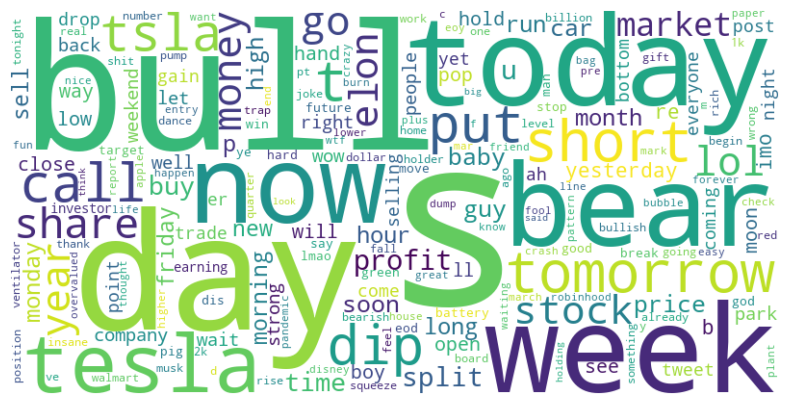

In [12]:
from wordcloud import WordCloud

# Obtener las palabras más frecuentes para las 5 compañías
words_filtered = word_count_filtered.toPandas()
words_str_filtered = ' '.join(words_filtered['word'])

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(words_str_filtered)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## 6.- Text cleaning

In [13]:
import re
import emoji
import string

# Función para limpiar texto
def clean_text(tweet):
    # Eliminar emojis
    tweet = emoji.replace_emoji(tweet, replace='')  # Elimina los emojis

    # Eliminar menciones de usuarios (palabras que empiezan con '@')
    tweet = re.sub(r'@\w+', '', tweet)

    # Eliminar URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)

    # Eliminar hashtags (si no quieres conservar los hashtags)
    tweet = re.sub(r'#\w+', '', tweet)

    # Eliminar puntuación
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Eliminar números (si no son relevantes para el análisis)
    tweet = re.sub(r'\d+', '', tweet)

    # Convertir a minúsculas
    tweet = tweet.lower()

    # Eliminar espacios extra
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet

# Convertir la función en un UDF para PySpark
clean_text_udf = udf(clean_text, StringType())

In [14]:
from pyspark.sql.functions import regexp_replace

# Eliminar menciones (@usuario) y enlaces (http://...)
df_cleaned = tweets.withColumn("cleaned_tweet", clean_text_udf(tweets['tweet']))

# Mostrar tweets limpiados
df_cleaned.select('tweet','cleaned_tweet').show(20)


+--------------------+--------------------+
|               tweet|       cleaned_tweet|
+--------------------+--------------------+
|$TSLA Daddy's dri...|tsla daddys drink...|
|$TSLA happy new y...|tsla happy new ye...|
|"$TSLA haha just ...|tsla haha just a ...|
|$TSLA NOBODY: Gas...|tsla nobody gas c...|
|$TSLA  I must ris...|tsla i must rise ...|
|$TSLA shorts are ...|tsla shorts are f...|
|$TSLA Don’t short...|tsla don’t short ...|
|$TSLA 🐻 not see ...|tsla not see anyt...|
|$TSLA  can one he...|tsla can one hear...|
|$TSLA Ignore the ...|tsla ignore the c...|
|$TSLA  Squeal lik...|tsla squeal like ...|
|$TSLA shorts thou...|tsla shorts thoug...|
|$TSLA if you had ...|tsla if you had o...|
|Once again $TSLA ...|once again tsla k...|
|$TSLA BUT BUTT WW...|tsla but butt ww ...|
|$TSLA Congratulat...|tsla congratulati...|
|$TSLA these bears...|tsla these bears ...|
|$TSLA Top of the ...|tsla top of the c...|
|$TSLA wow jpm wit...|tsla wow jpm with...|
|$DIS Just keep fa...|dis just ke

# Sentiment analysis for Tweets

### Implementation Textblob

In [15]:
from textblob import TextBlob

# Función para analizar el sentimiento usando TextBlob
def analyze_sentiment(text):
    try:
        blob = TextBlob(text)
        # Polarity: -1 (negativo) a 1 (positivo)
        return blob.sentiment.polarity
    except Exception as e:
        return None

# Crear un UDF (User Defined Function) en PySpark para aplicar el análisis de sentimiento
sentiment_udf = udf(analyze_sentiment, FloatType())

# Aplicar el análisis de sentimiento sobre la columna 'tweet' para las 5 compañías
df_sentiment = df_cleaned.withColumn('sentiment', sentiment_udf(df_cleaned['tweet']))

# Mostrar las primeras filas con el sentimiento calculado
df_sentiment.select('tweet', 'sentiment').show(10)


+--------------------+----------+
|               tweet| sentiment|
+--------------------+----------+
|$TSLA Daddy's dri...|   0.15625|
|$TSLA happy new y...|0.46818182|
|"$TSLA haha just ...|       0.5|
|$TSLA NOBODY: Gas...|      -0.2|
|$TSLA  I must ris...|       0.5|
|$TSLA shorts are ...|       0.0|
|$TSLA Don’t short...|       0.4|
|$TSLA 🐻 not see ...|      0.05|
|$TSLA  can one he...|       0.0|
|$TSLA Ignore the ...|       1.0|
+--------------------+----------+
only showing top 10 rows



### Implementation Vander

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType


In [17]:
# Inicializamos el analizador de VADER
analyzer = SentimentIntensityAnalyzer()

In [18]:
# Función para calcular el sentimiento usando VADER
def get_sentiment(tweet):
    sentiment_score = analyzer.polarity_scores(tweet)
    return sentiment_score['compound']  # La clave 'compound' es la polaridad global
# Convertir la función en un UDF de PySpark
sentiment_udf = udf(get_sentiment, FloatType())

In [19]:
# Aplicar el análisis de sentimiento a la columna 'tweet'
df_sentiment = tweets.withColumn("sentiment", sentiment_udf(tweets['tweet']))

# Mostrar los primeros resultados con el sentimiento calculado
df_sentiment.select('tweet', 'sentiment').show(10)


+--------------------+---------+
|               tweet|sentiment|
+--------------------+---------+
|$TSLA Daddy's dri...|      0.0|
|$TSLA happy new y...|   0.7506|
|"$TSLA haha just ...|   0.9371|
|$TSLA NOBODY: Gas...|  -0.9588|
|$TSLA  I must ris...|   0.9876|
|$TSLA shorts are ...|  -0.4939|
|$TSLA Don’t short...|   0.5267|
|$TSLA 🐻 not see ...|  -0.2755|
|$TSLA  can one he...|   0.7184|
|$TSLA Ignore the ...|   0.7256|
+--------------------+---------+
only showing top 10 rows



I choosen Vader, because is more for informal text

### Categorizate 

In [20]:
# Función para categorizar el sentimiento
def sentiment_category(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

# Crear un UDF para aplicar la categorización
sentiment_category_udf = udf(sentiment_category, StringType())

# Añadir la columna con la categoría del sentimiento
df_sentiment_with_category = df_sentiment.withColumn('sentiment_category', sentiment_category_udf(df_sentiment['sentiment']))

# Mostrar las primeras filas con la categoría de sentimiento
df_sentiment_with_category.select('tweet', 'sentiment', 'sentiment_category').show(10)


+--------------------+---------+------------------+
|               tweet|sentiment|sentiment_category|
+--------------------+---------+------------------+
|$TSLA Daddy's dri...|      0.0|           neutral|
|$TSLA happy new y...|   0.7506|          positive|
|"$TSLA haha just ...|   0.9371|          positive|
|$TSLA NOBODY: Gas...|  -0.9588|          negative|
|$TSLA  I must ris...|   0.9876|          positive|
|$TSLA shorts are ...|  -0.4939|          negative|
|$TSLA Don’t short...|   0.5267|          positive|
|$TSLA 🐻 not see ...|  -0.2755|          negative|
|$TSLA  can one he...|   0.7184|          positive|
|$TSLA Ignore the ...|   0.7256|          positive|
+--------------------+---------+------------------+
only showing top 10 rows



### Length distribution of tweets (Visualization)

In [21]:
# Agrupar por 'ticker' y calcular el promedio de 'sentiment' y la cantidad de cada categoría de sentimiento
sentiment_stats = df_sentiment_with_category.groupBy('ticker', 'sentiment_category') \
    .count() \
    .orderBy('ticker', 'sentiment_category')

# Mostrar estadísticas de sentimiento por ticker
sentiment_stats.show()


+------+------------------+-----+
|ticker|sentiment_category|count|
+------+------------------+-----+
|   BAC|          negative|   15|
|   BAC|           neutral|   19|
|   BAC|          positive|   31|
|   DIS|          negative|  103|
|   DIS|           neutral|   89|
|   DIS|          positive|  240|
|    PG|          negative|    2|
|    PG|          positive|    1|
|  TSLA|          negative|  817|
|  TSLA|           neutral|  856|
|  TSLA|          positive| 2668|
|   WMT|          negative|   27|
|   WMT|           neutral|   27|
|   WMT|          positive|   64|
+------+------------------+-----+



In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_distribution_tweets(data, title): 
    # Convertir el dataframe de Spark a pandas para graficar
    #pandas_df_sentiment = df_sentiment_with_category.toPandas()
    pandas_df_sentiment = data
    
    # Graficar la distribución de los sentimientos por ticker
    plt.figure(figsize=(10, 6))
    sns.countplot(x='ticker', hue='sentiment_category', data=pandas_df_sentiment)
    plt.title(title)
    plt.xlabel("Companies")
    plt.ylabel("Number of Tweets")
    plt.show()

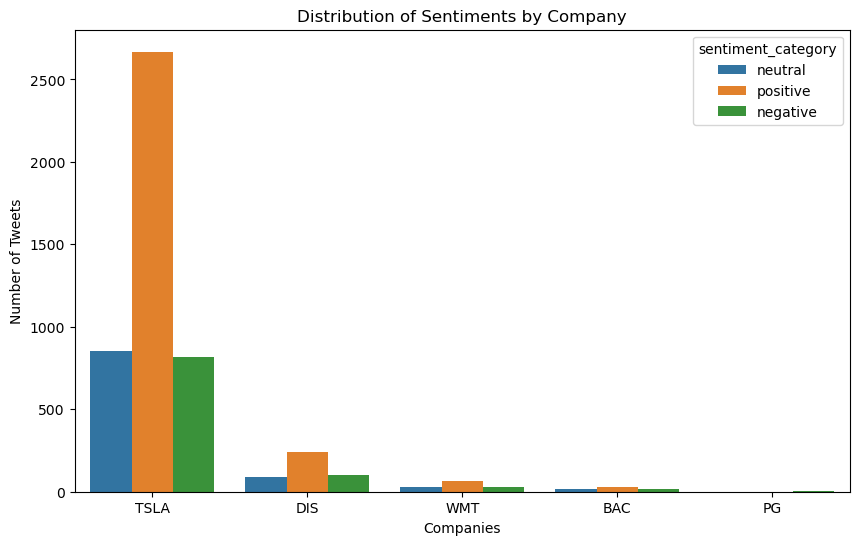

In [23]:
show_distribution_tweets(df_sentiment_with_category.toPandas(), "Distribution of Sentiments by Company")

# Processing Tweets

In [24]:
df_sentiment_with_category.select('*').show(10)

+------+----------+------+--------------------+---------+------------------+
|    id|      date|ticker|               tweet|sentiment|sentiment_category|
+------+----------+------+--------------------+---------+------------------+
|100002|01/01/2020|  TSLA|$TSLA Daddy's dri...|      0.0|           neutral|
|100004|01/01/2020|  TSLA|$TSLA happy new y...|   0.7506|          positive|
|100005|01/01/2020|  TSLA|"$TSLA haha just ...|   0.9371|          positive|
|100006|01/01/2020|  TSLA|$TSLA NOBODY: Gas...|  -0.9588|          negative|
|100019|03/01/2020|  TSLA|$TSLA  I must ris...|   0.9876|          positive|
|100020|03/01/2020|  TSLA|$TSLA shorts are ...|  -0.4939|          negative|
|100021|03/01/2020|  TSLA|$TSLA Don’t short...|   0.5267|          positive|
|100023|03/01/2020|  TSLA|$TSLA 🐻 not see ...|  -0.2755|          negative|
|100024|03/01/2020|  TSLA|$TSLA  can one he...|   0.7184|          positive|
|100025|03/01/2020|  TSLA|$TSLA Ignore the ...|   0.7256|          positive|


Selecting only imortant columns


In [25]:
df_setiment_final = df_sentiment_with_category.select('date', 'ticker', 'sentiment','sentiment_category')
df_setiment_final.show(5)
print(df_sentiment.count())

+----------+------+---------+------------------+
|      date|ticker|sentiment|sentiment_category|
+----------+------+---------+------------------+
|01/01/2020|  TSLA|      0.0|           neutral|
|01/01/2020|  TSLA|   0.7506|          positive|
|01/01/2020|  TSLA|   0.9371|          positive|
|01/01/2020|  TSLA|  -0.9588|          negative|
|03/01/2020|  TSLA|   0.9876|          positive|
+----------+------+---------+------------------+
only showing top 5 rows

4959


Grouping register with the same date and company

In [26]:
from pyspark.sql import functions as F

# Agrupar por 'date' y 'ticker' y calcular el promedio del 'sentiment'
df_sentiment_avg = df_setiment_final.groupBy('date', 'ticker') \
    .agg(
        F.avg('sentiment').alias('sentiment')
    )

df_sentiment_avg.show(5)


+----------+------+------------------+
|      date|ticker|         sentiment|
+----------+------+------------------+
|24/01/2020|  TSLA|0.2638999968767166|
|03/02/2020|  TSLA|0.4597533330321312|
|31/03/2020|   WMT|             0.875|
|01/07/2020|  TSLA| 0.248860003054142|
|03/11/2020|   WMT| 0.769599974155426|
+----------+------+------------------+
only showing top 5 rows



In [27]:
# Clasificar el sentimiento según el valor del promedio
df_sentiment_final = df_sentiment_avg.withColumn(
    'sentiment_category',
    F.when(df_sentiment_avg['sentiment'] > 0, 'Positive')
    .when(df_sentiment_avg['sentiment'] < 0, 'Negative')
    .otherwise('Neutral')
)

# Mostrar el resultado
df_sentiment_final.show(5)
print(df_sentiment_final.count())

+----------+------+------------------+------------------+
|      date|ticker|         sentiment|sentiment_category|
+----------+------+------------------+------------------+
|24/01/2020|  TSLA|0.2638999968767166|          Positive|
|03/02/2020|  TSLA|0.4597533330321312|          Positive|
|31/03/2020|   WMT|             0.875|          Positive|
|01/07/2020|  TSLA| 0.248860003054142|          Positive|
|03/11/2020|   WMT| 0.769599974155426|          Positive|
+----------+------+------------------+------------------+
only showing top 5 rows

534


Distribucion por fecha y empresa

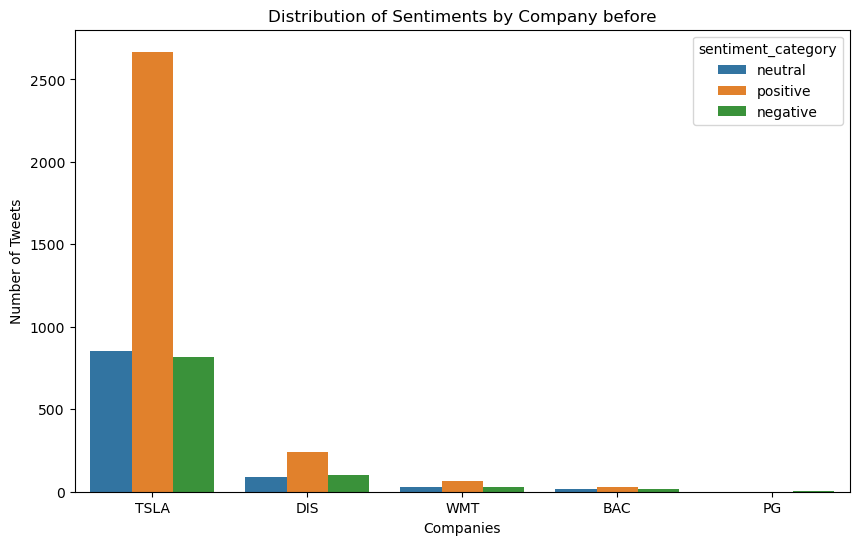

In [28]:
show_distribution_tweets(df_sentiment_with_category.toPandas(), "Distribution of Sentiments by Company before")

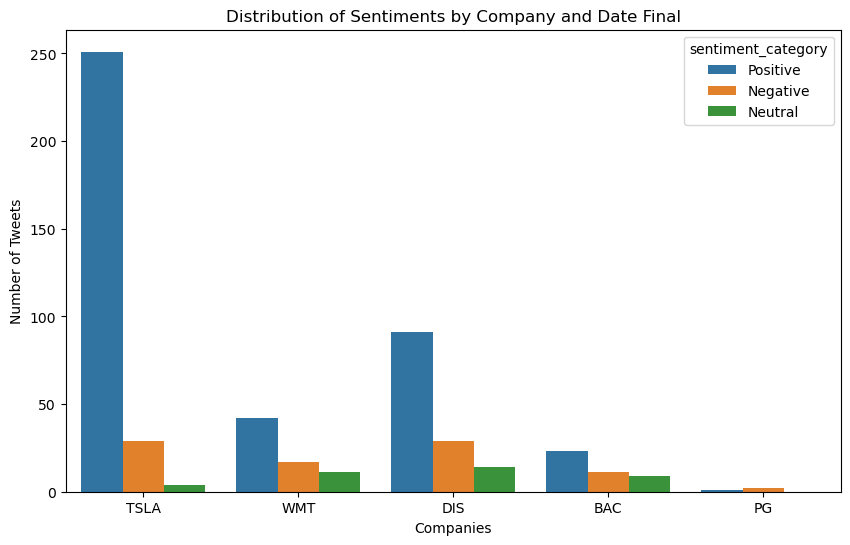

In [29]:
show_distribution_tweets(df_sentiment_final.toPandas(), "Distribution of Sentiments by Company and Date Final")

# Processing Prices

In [30]:
prices = spark.sql("Select * from prices;")
prices.show(5)
print(prices.count())

+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      Date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
|2020-01-03|29.366666793823242|30.266666412353516|29.128000259399414|29.534000396728516|29.534000396728516|266677500|   TSLA|
|2020-01-06|29.364667892456055|30.104000091552734|29.333332061767578|  30.1026668548584|  30.1026668548584|151995000|   TSLA|
|2020-01-07|30.760000228881836|31.441999435424805|30.224000930786133|31.270666122436523|31.270666122436523|268231500| 

In [31]:
# Drop columns 
prices = prices[['Date', 'Close', 'Volume', 'company']]  # Mantén solo las columnas que necesitas
prices.show(5)
print(prices.count())

+----------+------------------+---------+-------+
|      Date|             Close|   Volume|company|
+----------+------------------+---------+-------+
|2019-12-31|  27.8886661529541|154285500|   TSLA|
|2020-01-02| 28.68400001525879|142981500|   TSLA|
|2020-01-03|29.534000396728516|266677500|   TSLA|
|2020-01-06|  30.1026668548584|151995000|   TSLA|
|2020-01-07|31.270666122436523|268231500|   TSLA|
+----------+------------------+---------+-------+
only showing top 5 rows

1270


## Join Data

In [32]:
# Convertir la fecha en formato adecuado
from pyspark.sql.functions import to_date

tweets_df = df_sentiment_final.withColumn("date", to_date(df_sentiment_final["date"], "dd/MM/yyyy"))

prices_df = prices.withColumn("date", to_date(prices["Date"], "yyyy-MM-dd"))


In [33]:
tweets_df.show(3)
print(tweets_df.count())

prices_df.show(3)
print(prices_df.count())

+----------+------+------------------+------------------+
|      date|ticker|         sentiment|sentiment_category|
+----------+------+------------------+------------------+
|2020-01-24|  TSLA|0.2638999968767166|          Positive|
|2020-02-03|  TSLA|0.4597533330321312|          Positive|
|2020-03-31|   WMT|             0.875|          Positive|
+----------+------+------------------+------------------+
only showing top 3 rows

534
+----------+------------------+---------+-------+
|      date|             Close|   Volume|company|
+----------+------------------+---------+-------+
|2019-12-31|  27.8886661529541|154285500|   TSLA|
|2020-01-02| 28.68400001525879|142981500|   TSLA|
|2020-01-03|29.534000396728516|266677500|   TSLA|
+----------+------------------+---------+-------+
only showing top 3 rows

1270


In [34]:
# Unir los datos por fecha y ticker
merged_df = tweets_df.join(prices_df, (tweets_df["date"] == prices_df["date"]) & (tweets_df["ticker"] == prices_df["company"]), "right")
merged_df.show(5)
print(merged_df.count())

+----------+------+--------------------+------------------+----------+------------------+---------+-------+
|      date|ticker|           sentiment|sentiment_category|      date|             Close|   Volume|company|
+----------+------+--------------------+------------------+----------+------------------+---------+-------+
|      null|  null|                null|              null|2019-12-31|  27.8886661529541|154285500|   TSLA|
|2020-01-02|  TSLA|-0.32910001277923584|          Negative|2020-01-02| 28.68400001525879|142981500|   TSLA|
|2020-01-03|  TSLA| 0.36481667558352154|          Positive|2020-01-03|29.534000396728516|266677500|   TSLA|
|2020-01-06|  TSLA| 0.20195000618696213|          Positive|2020-01-06|  30.1026668548584|151995000|   TSLA|
|2020-01-07|  TSLA|  0.1834687520749867|          Positive|2020-01-07|31.270666122436523|268231500|   TSLA|
+----------+------+--------------------+------------------+----------+------------------+---------+-------+
only showing top 5 rows

127

In [35]:
# Eliminar columnas duplicadas, manteniendo solo las necesarias
merged_df = merged_df.drop(tweets_df["date"])
merged_df.show(5)
print(merged_df.count())

+------+--------------------+------------------+----------+------------------+---------+-------+
|ticker|           sentiment|sentiment_category|      date|             Close|   Volume|company|
+------+--------------------+------------------+----------+------------------+---------+-------+
|  null|                null|              null|2019-12-31|  27.8886661529541|154285500|   TSLA|
|  TSLA|-0.32910001277923584|          Negative|2020-01-02| 28.68400001525879|142981500|   TSLA|
|  TSLA| 0.36481667558352154|          Positive|2020-01-03|29.534000396728516|266677500|   TSLA|
|  TSLA| 0.20195000618696213|          Positive|2020-01-06|  30.1026668548584|151995000|   TSLA|
|  TSLA|  0.1834687520749867|          Positive|2020-01-07|31.270666122436523|268231500|   TSLA|
+------+--------------------+------------------+----------+------------------+---------+-------+
only showing top 5 rows

1270


In [36]:
# Eliminar columnas duplicadas, manteniendo solo las necesarias
merged_df = merged_df.drop(tweets_df["ticker"])
merged_df.show(5)
print(merged_df.count())

+--------------------+------------------+----------+------------------+---------+-------+
|           sentiment|sentiment_category|      date|             Close|   Volume|company|
+--------------------+------------------+----------+------------------+---------+-------+
|                null|              null|2019-12-31|  27.8886661529541|154285500|   TSLA|
|-0.32910001277923584|          Negative|2020-01-02| 28.68400001525879|142981500|   TSLA|
| 0.36481667558352154|          Positive|2020-01-03|29.534000396728516|266677500|   TSLA|
| 0.20195000618696213|          Positive|2020-01-06|  30.1026668548584|151995000|   TSLA|
|  0.1834687520749867|          Positive|2020-01-07|31.270666122436523|268231500|   TSLA|
+--------------------+------------------+----------+------------------+---------+-------+
only showing top 5 rows

1270


## Analysis and Preparation for Prediction

In [40]:
# Filtrar los datos para las 5 compañías seleccionadas
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

# Crear un diccionario para almacenar los DataFrames filtrados por empresa
company_data = {}

for company in companies:
    company_data[company] = merged_df.filter(merged_df['company'] == company)

    company_data[company].show(5)
    # Contar cuántos valores nulos hay en la columna 'sentiment'
    null_sentiment_count = company_data[company].filter(col('sentiment').isNull()).count()
    
    # Imprimir la cantidad de valores nulos en 'sentiment'    
    print(f"Cantidad de valores en la tabla ' para {company}: {company_data[company].count()}")
    print(f"Cantidad de valores nulos en 'sentiment' para {company}: {null_sentiment_count}")




+---------+------------------+----------+------------------+--------+-------+
|sentiment|sentiment_category|      date|             Close|  Volume|company|
+---------+------------------+----------+------------------+--------+-------+
|     null|              null|2019-12-31|35.220001220703125|29630100|    BAC|
|     null|              null|2020-01-02| 35.63999938964844|37614200|    BAC|
|     null|              null|2020-01-03|34.900001525878906|50357900|    BAC|
|     null|              null|2020-01-06|34.849998474121094|42185000|    BAC|
|     null|              null|2020-01-07|34.619998931884766|34149000|    BAC|
+---------+------------------+----------+------------------+--------+-------+
only showing top 5 rows

Cantidad de valores en la tabla ' para BAC: 254
Cantidad de valores nulos en 'sentiment' para BAC: 212
+------------------+------------------+----------+------------------+-------+-------+
|         sentiment|sentiment_category|      date|             Close| Volume|company

In [ ]:
company_data[

In [42]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Crear un diccionario para almacenar los DataFrames con características de lags
company_data_lagged = {}

for company in companies:
    df = company_data[company]
    window_spec = Window.partitionBy("ticker").orderBy("date")

    # Crear lags de los precios de cierre
    df = df.withColumn("Close_lag_1", lag("Close", 1).over(window_spec))
    df = df.withColumn("Close_lag_3", lag("Close", 3).over(window_spec))
    df = df.withColumn("Close_lag_7", lag("Close", 7).over(window_spec))

    # Eliminar filas con valores nulos
    df = df.dropna(subset=["Close_lag_1", "Close_lag_3", "Close_lag_7"])
    
    company_data_lagged[company] = df



AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `ticker` cannot be resolved. Did you mean one of the following? [`date`, `sentiment`, `sentiment_category`, `spark_catalog`.`ca2`.`prices`.`Close`, `spark_catalog`.`ca2`.`prices`.`Volume`].;
'Project [sentiment#546, sentiment_category#572, date#711, Close#617, Volume#619, company#620, lag(Close#617, -1, null) windowspecdefinition('ticker, date#711 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS Close_lag_1#986]
+- Filter (company#620 = BAC)
   +- Project [sentiment#546, sentiment_category#572, date#711, Close#617, Volume#619, company#620]
      +- Project [ticker#13, sentiment#546, sentiment_category#572, date#711, Close#617, Volume#619, company#620]
         +- Join RightOuter, ((date#706 = date#711) AND (ticker#13 = company#620))
            :- Project [to_date(date#12, Some(dd/MM/yyyy), Some(Europe/Dublin)) AS date#706, ticker#13, sentiment#546, sentiment_category#572]
            :  +- Project [date#12, ticker#13, sentiment#546, CASE WHEN (sentiment#546 > cast(0 as double)) THEN Positive WHEN (sentiment#546 < cast(0 as double)) THEN Negative ELSE Neutral END AS sentiment_category#572]
            :     +- Aggregate [date#12, ticker#13], [date#12, ticker#13, avg(sentiment#402) AS sentiment#546]
            :        +- Project [date#12, ticker#13, sentiment#402, sentiment_category#421]
            :           +- Project [id#11, date#12, ticker#13, tweet#14, sentiment#402, sentiment_category(sentiment#402)#420 AS sentiment_category#421]
            :              +- Project [id#11, date#12, ticker#13, tweet#14, get_sentiment(tweet#14)#401 AS sentiment#402]
            :                 +- Filter ticker#13 IN (BAC,DIS,PG,TSLA,WMT)
            :                    +- Project [id#11, date#12, ticker#13, tweet#14]
            :                       +- SubqueryAlias spark_catalog.ca2.tweets
            :                          +- Relation spark_catalog.ca2.tweets[id#11,date#12,ticker#13,tweet#14] parquet
            +- Project [to_date(Date#613, Some(yyyy-MM-dd), Some(Europe/Dublin)) AS date#711, Close#617, Volume#619, company#620]
               +- Project [Date#613, Close#617, Volume#619, company#620]
                  +- Project [Date#613, Open#614, High#615, Low#616, Close#617, Adj Close#618, Volume#619, company#620]
                     +- SubqueryAlias spark_catalog.ca2.prices
                        +- Relation spark_catalog.ca2.prices[Date#613,Open#614,High#615,Low#616,Close#617,Adj Close#618,Volume#619,company#620] parquet


In [ ]:
# Ver los primeros registros para AAPL con lags
company_data_lagged['BAC'].show(5)


### ARIMA Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Suponiendo que 'df' es un DataFrame con la columna "Close" de precios de las acciones
model = ARIMA(merged_df['Close'], order=(5,1,0))  # Parametros (p,d,q) del ARIMA
model_fit = model.fit()

# Hacer predicciones
predictions = model_fit.forecast(steps=7)  # Predecir para los próximos 7 días


### LSTM Model

# Casandra

In [43]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

# Configura la conexión a Cassandra
cluster = Cluster(['localhost'])  # Reemplaza con tu host de Cassandra
session = cluster.connect()

# Si usas autenticación
# auth_provider = PlainTextAuthProvider(username='your_username', password='your_password')
# cluster = Cluster(['localhost'], auth_provider=auth_provider)
# session = cluster.connect()

# Crear el keyspace en Cassandra
keyspace_name = "test_1"
cql_create_keyspace = f"""
    CREATE KEYSPACE IF NOT EXISTS {keyspace_name} 
    WITH replication = {{'class': 'SimpleStrategy', 'replication_factor': 1}};
"""
session.execute(cql_create_keyspace)

# Ejecutar una consulta para obtener todos los keyspaces
rows = session.execute("SELECT keyspace_name FROM system_schema.keyspaces")

# Mostrar los keyspaces
for row in rows:
    print(row.keyspace_name)

# Cerrar la conexión
cluster.shutdown()


test_keyspace
ycsb
test_1
vehicle_tracker
system_auth
system_schema
system_distributed
system
test_keyspace2
system_traces
benchmark


In [44]:
from pyspark.sql import SparkSession

# Crear la sesión de Spark
spark = SparkSession.builder \
    .appName("CassandraApp") \
    .config("spark.cassandra.connection.host", "localhost") \
    .getOrCreate()

try:
    # Leer datos desde una tabla de Cassandra
    df = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="table1", keyspace="test_1") \
        .load()
    
    # Mostrar los datos
    df.show()
except Exception as e:
    print("Error al cargar el conector de Cassandra:", e)


24/12/06 16:10:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Error al cargar el conector de Cassandra: An error occurred while calling o337.load.
: java.lang.NoClassDefFoundError: com/datastax/spark/connector/TableRef
	at org.apache.spark.sql.cassandra.DefaultSource$.TableRefAndOptions(DefaultSource.scala:142)
	at org.apache.spark.sql.cassandra.DefaultSource.createRelation(DefaultSource.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:346)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:172)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingM